# Predicting Magic: the Gathering Card Types Based on Artwork
Authors: David Kim, Ericka Koyama, James DeSelms, Jess Sparrow
# Intro
Magic: the Gathering (or sometimes just Magic) is a trading card game. As such, the game is played using small objects resembling playing cards. These cards have certain attributes, such as cost, color, rarity, and type. These types represent different things within the context of the game. For example, a creature card might represent a monster, such as the dragon depicted in Balefire Dragon, while the Instant card Lightning Bolt represents a magical bolt of lightning. These attributes are brought to life by art, drawn by many different artists on commission. Since these attributes are so distinct in their flavor, might it be possible to train a model to predict which type a card is based on its art?
# Description
Scryfall is an online resource that allows people to quickly and efficiently search for Magic cards. It also provides a useful API. Scrython is a Python wrapper for this API. Magic cards are released in sets, usually of about 200-300 cards. These sets usually are themed in one way or another. For example, the set Battle for Zendikar is set on the in-game world of Zendikar, and the art of the cards reflects this. Kaladesh and Aether Revolt are two such sets, released back to back. They are set on the steampunk, India-inspired world of Kaladesh. This dataset uses a subset of cards from these two sets, using Scrython to gather them. In more exact terms, it uses Scrython to query Scryfall for all cards from the sets Kaladesh and Aether Revolt, except for those with the supertypes Legendary or those with the type Artifact Creature or the subtype Vehicle. This limits the dataset into the six categories of Artifact, Enchantment, Instant, Sorcery, Creature, and Land. This dataset is further pared down by selecting only twenty cards of each type, and combining the types Instant and Sorcery into one. The two types are combined since, in terms of flavor, there is minimal difference between the two. This careful selection and modification is done to make cards and categories less dissonant in their art style. The four dimensional image data of the art of the cards are used as predictors for the five aforementioned categories of Artifact, Enchantment, Instant and Sorcery, Creature, and Land.

Import everything necessary.

In [1]:
!pip install scrython
!pip install asyncio
#Import numpy.
import numpy as np
#Import pandas.
import pandas as pd
#Import scrython. Be sure to install it with pip or what have you.
import scrython
#Import seaborn.
import seaborn as sns
#Import matplotlib
import matplotlib.pyplot as plt
#Import nest_asyncio.
import nest_asyncio
#Import train_test_split from model sklearn.
from sklearn.model_selection import train_test_split
#Import for confusion matrix viz
from sklearn.metrics import confusion_matrix
#Import io from skimage.
from skimage import io
#Import GaussianNB from sklearn.
from sklearn.naive_bayes import GaussianNB
#Import Isomap from sklearn.
from sklearn.manifold import Isomap
#Import accuracy score from sklearn.
from sklearn.metrics import accuracy_score
import time

Create some variables to make code more clear.

In [2]:
#The number of cards per type to use.
no_cards_per_type = 25;
#The number of card types.
no_types = 5;

Since the program uses an external API, it needs to be able to wait for a response before continuing.

In [3]:
#Apply nest_asyncio.
nest_asyncio.apply()

Query the API for some cards.

In [4]:
cards = scrython.cards.Search(q='(set:kld or set:aer) and ((-type:"artifact creature" -type:"legendary" -type:vehicle -type:basic) or (!Plains or !Island or !Swamp or !Mountain or !Forest)) unique:prints')
#Load both of those cards into a dataframe.
df = pd.DataFrame(cards.data())
page_no = 2
while(cards.has_more()):
    time.sleep(.2)
    cards = scrython.cards.Search(q='(set:kld or set:aer) and ((-type:"artifact creature" -type:"legendary" -type:vehicle -type:basic) or (!Plains or !Island or !Swamp or !Mountain or !Forest)) unique:prints', page=page_no)
    page_no = page_no + 1
    df2 = pd.DataFrame(cards.data())
    df = pd.concat([df, df2], ignore_index=True)

Load those cards into a dataframe and clear up the dataframe.

In [5]:
#Split the image_uris into three columns.
df = pd.concat([df.drop(['image_uris'], axis=1), df['image_uris'].apply(pd.Series)], axis=1)
#Drop uneeded columns.
df = df.replace(regex=r'^Creature(.*)', value='Creature')
df = df.drop(['id', 'object', 'oracle_id', 'multiverse_ids', 'mtgo_id', 'mtgo_foil_id', 'tcgplayer_id', 'cardmarket_id', 'lang', 
    'released_at', 'uri', 'scryfall_uri', 'layout', 'highres_image', 'image_status', 'keywords', 'legalities', 'games',
    'reserved', 'foil', 'nonfoil', 'oversized', 'promo', 'reprint', 'variation', 'set_type', 'set_uri', 'set_search_uri',
    'scryfall_set_uri', 'rulings_uri', 'prints_search_uri', 'collector_number', 'digital', 'rarity', 'flavor_text', 'set',
    'card_back_id', 'artist_ids', 'illustration_id', 'border_color', 'frame', 'full_art', 'textless', 'booster', 'set_name',
    'story_spotlight', 'edhrec_rank', 'prices', 'related_uris', 'purchase_uris', 'power', 'toughness', 'border_crop',
    'produced_mana', 'all_parts', 'watermark', 'promo_types', 'small', 'normal', 'large', 'png'], axis=1)
#Use regex to manipulate typlines so they contain no subtypes or supertypes.
df = df.replace(regex=r'^Artifact(.*)', value='Artifact')
df = df.replace(regex=r'^Enchantment(.*)', value='Enchantment')
#Combine instant and sorcery into one type.
df = df.replace(regex=r'^Sorcery(.*)', value='Instant or Sorcery')
df = df.replace(regex=r'^Instant(.*)', value='Instant or Sorcery')
#Change all Basic Lands into just Land.
df = df.replace(regex=r'^Basic(.*)', value='Land')
# Try to get even number of each card type
df = df.groupby('type_line').head(no_cards_per_type)
#Turn colors into a concetenated string (e.g., WUBRG) instead of a list (e.g., [W,U,B,R,G]).
df['colors'] = df['colors'].apply(lambda x: 'C' if not x else ''.join(x))
#print some info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 0 to 322
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            125 non-null    object 
 1   mana_cost       125 non-null    object 
 2   cmc             125 non-null    float64
 3   type_line       125 non-null    object 
 4   oracle_text     125 non-null    object 
 5   colors          125 non-null    object 
 6   color_identity  125 non-null    object 
 7   artist          125 non-null    object 
 8   art_crop        125 non-null    object 
dtypes: float64(1), object(8)
memory usage: 9.8+ KB


Fetch image artwork

In [6]:
#Take the image urls.
image_urls = df['art_crop'].values.tolist()
#Take the raw image data.
images = np.array([io.imread(url) for url in image_urls])

View example artwork for each type_line

<ipython-input-7-57017392af66>:14: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.text(0.05, 0.05, str(df.iloc[idx_of_each_type[i]].type_line),


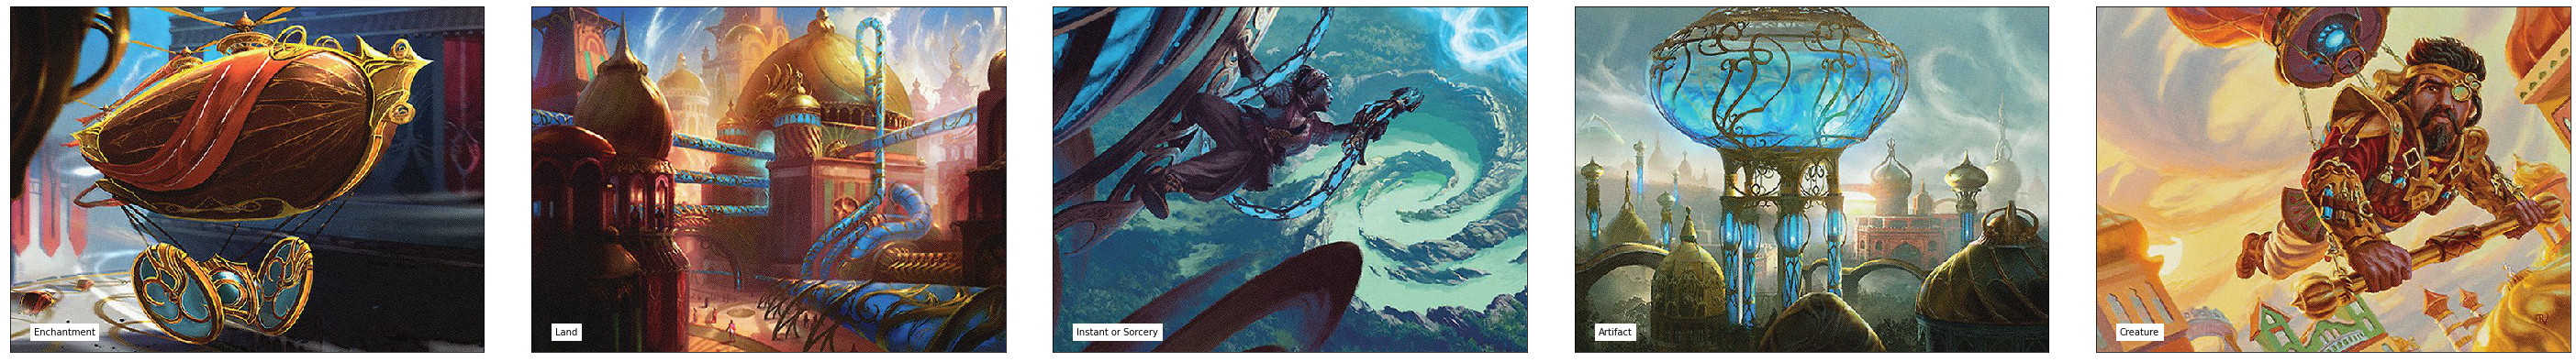

In [7]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 5, figsize=(50, 30),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
idx_of_each_type = [
  df.index[df['type_line'] == 'Enchantment'][0],
  df.index[df['type_line'] == 'Land'][0],
  df.index[df['type_line'] == 'Instant or Sorcery'][0],
  df.index[df['type_line'] == 'Artifact'][0],
  df.index[df['type_line'] == 'Creature'][0]
]
for i, ax in enumerate(axes.flat):
  ax.imshow(images[idx_of_each_type[i]], cmap='binary', interpolation='nearest')
  ax.text(0.05, 0.05, str(df.iloc[idx_of_each_type[i]].type_line),
            transform=ax.transAxes, color='black', backgroundColor='white')

Prepare to make predictions.

In [8]:
#Get the dimensions for reshaping.
nsamples, nx, ny, nz = images.data.shape
#Set X to the reshaped images.
X = images.reshape((nsamples,nx*ny*nz))

#Isomap to visualize distribution
iso = Isomap(n_components=4)
#Fit X.
iso.fit(X)
#Transform X.
data_projected = iso.transform(X)

#Set y to the type lines.
y = df['type_line']
#Set Xtrain, Xtest, ytrain, and ytest to randomly distributed cards.
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=25, train_size=100, random_state=7)

How is the data distributed?

[Text(1, 0, 'Instant or Sorcery'),
 Text(1, 1, 'Enchantment'),
 Text(1, 2, 'Creature'),
 Text(1, 3, 'Artifact'),
 Text(1, 4, 'Land')]

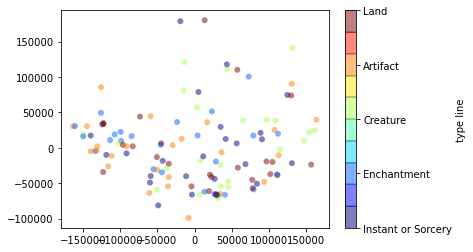

In [9]:
num_type_line_categories = 5 # number of possible type_line values
factorized_type_lines = codes, uniques = df['type_line'].factorize()
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=codes,
            edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('jet', 10))
cbar = plt.colorbar(label='type line', ticks=(range(num_type_line_categories)), drawedges=True)
cbar.ax.set_yticklabels(uniques) # convert factorized type_lines back to text for colorbar legend

Make predictions and print the accuracy.

In [10]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(Xtrain, ytrain)
#Test model performance.
y_model = model.predict(Xtest)
#Print the accuracy.
print(accuracy_score(ytest, y_model))

0.44


How did the predictions go? Which cards did the model get wrong?

Incorrect predictions:
                    name           type_line          prediction
0     Acrobatic Maneuver  Instant or Sorcery            Creature
1    Aerial Modification         Enchantment            Creature
4    Aetherborn Marauder            Creature                Land
5          Aether Chaser            Creature                Land
6   Aetherflux Reservoir            Artifact                Land
7      Aethergeode Miner            Creature  Instant or Sorcery
9             Aether Hub                Land            Artifact
10      Aether Inspector            Creature                Land
11       Aether Meltdown         Enchantment            Artifact
12       Aether Poisoner            Creature            Artifact
13  Aethersquall Ancient            Creature  Instant or Sorcery
14       Aetherstorm Roc            Creature            Artifact
15  Aetherstream Leopard            Creature         Enchantment
16        Aether Swooper            Creature  Instant or Sorcery
18

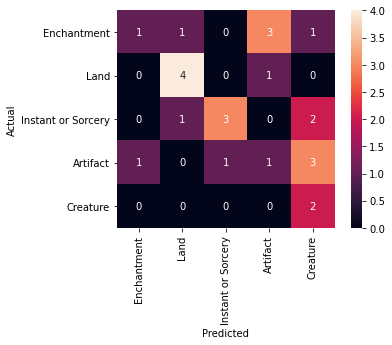

In [11]:
#Add a column to the dataframe that contains the predicted target value. It is NaN if there were no predictions.
df['prediction'] = pd.DataFrame(y_model)
#Set wrong equal to the cards where the prediction is wrong and not NaN.
wrong = df[(df['prediction'] != df['type_line']) & (~pd.isna(df['prediction']))]
#Print out those wrong cards.
print("Incorrect predictions:")
print(wrong[['name', 'type_line', 'prediction']])

labels = ['Enchantment', 'Land', 'Instant or Sorcery', 'Artifact', 'Creature']
mat = confusion_matrix(ytest, y_model, labels=labels)

sns.heatmap(mat, square=True, annot=True, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual');

From the confusion matrix, we can see that the Land type was frequently miscategorized as 'Creature'. We also see that at least once, every other card type was miscategorized as 'Creature'

Examples of most frequently miscategorized card

In [12]:
# row is actual value
# column is predicted value
mat_index_of_most_miscat = (0,0)
most_times_miscat = 0
for i, row in enumerate(mat):
    for j, cell in enumerate(row):
        num_cats = mat[i][j]
        if (i != j and num_cats > most_times_miscat):
          most_times_miscat = num_cats
          mat_index_of_most_miscat = (i, j)

# print example image from the most miscategorized
predicted_label = labels[mat_index_of_most_miscat[1]]
actual_label = labels[mat_index_of_most_miscat[0]]

# choose random image example of each
example_predicted = images[ df['type_line'] == predicted_label ][1]
example_actual = images[ df['type_line'] == actual_label ][1]

We take the most frequently miscategorized type_line and display an example of the predicted type_line and an actual type_line.

Predicted Label:  Artifact


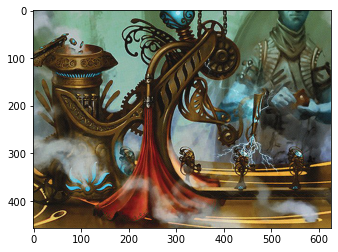

In [13]:
print('Predicted Label: ', predicted_label)
plt.figure()
plt.imshow(example_predicted)

Actual Label:  Enchantment


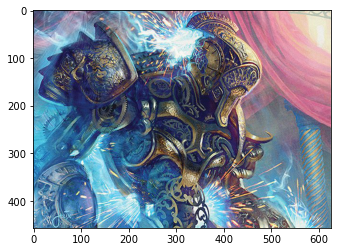

In [14]:
print('Actual Label: ', actual_label)
plt.figure()
plt.imshow(example_actual)

Which artists?

<AxesSubplot:>

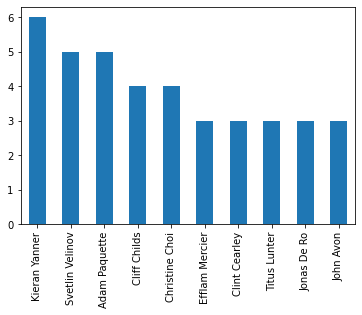

In [15]:
df['artist'].value_counts()[:10].plot.bar()

Which colors?

<AxesSubplot:>

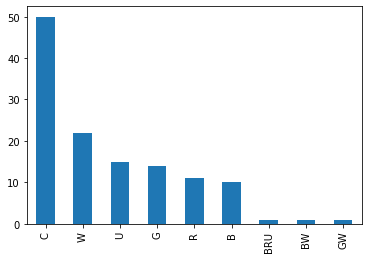

In [16]:
df['colors'].value_counts().plot.bar()

Plot out a heatmap of a few columns. I don't know if this actually means anything.

<AxesSubplot:>

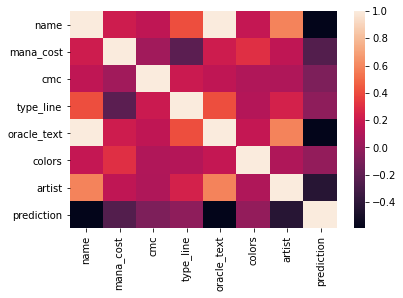

In [17]:
sns.heatmap(df.drop(['color_identity', 'art_crop'], axis=1).apply(lambda x: x.factorize()[0]).corr())

What are the most common type line artist combinations?

<AxesSubplot:xlabel='artist,type_line'>

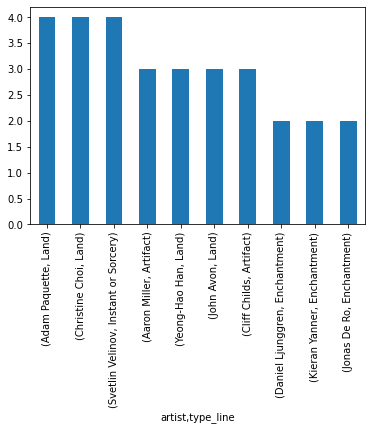

In [18]:
df.groupby('artist')['type_line'].value_counts().sort_values(ascending=False)[:10].plot.bar()

What are the most common artist color combinations?

<AxesSubplot:xlabel='artist,colors'>

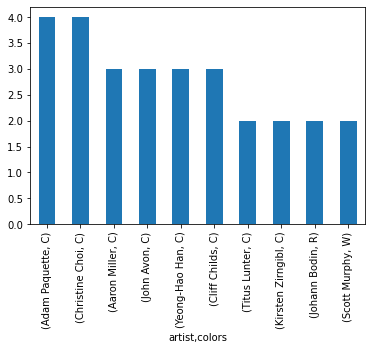

In [19]:
df.groupby('artist')['colors'].value_counts().sort_values(ascending=False)[:10].plot.bar()

What are the most common color type line combinations?

<AxesSubplot:xlabel='colors,type_line'>

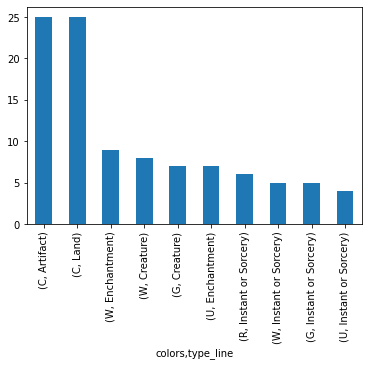

In [20]:
df.groupby('colors')['type_line'].value_counts().sort_values(ascending=False)[:10].plot.bar()